### Introduction

This is the code that can propagates
color over regions exhibiting pattern-continuity as well as intensity-
continuity. This method works effectively on colorizing
black-and-white manga which contains intensive amount of strokes,
hatching, halftoning and screening. Such fine details and discon-
tinuities in intensity introduce many difficulties to intensity-based
colorization methods. Once the user scribbles on the drawing, a
local, statistical based pattern feature obtained with Gabor wavelet
filters is applied to measure the pattern-continuity. The boundary is
then propagated by the distance regularized level set method that monitors the pattern-
continuity. Regions with open boundaries or multiple disjointed
regions with similar patterns can be sensibly segmented by a single
scribble. With the segmented regions, various colorization tech-
niques can be applied to replace colors, colorize with stroke preser-
vation, or even convert pattern to shading.


### Distance Regularized Level Set Method

Level set methods have been widely used in image processing and computer vision. In conventional level set formulations, the level set function typically develops irregularities during its evolution, which may cause numerical errors and eventually destroy the stability of the evolution. Therefore, a numerical remedy, called reinitialization, is typically applied to periodically replace the degraded level set function with a signed distance function. However, the practice of reinitialization not only raises serious problems as when and how it should be performed, but also affects numerical accuracy in an undesirable way. 

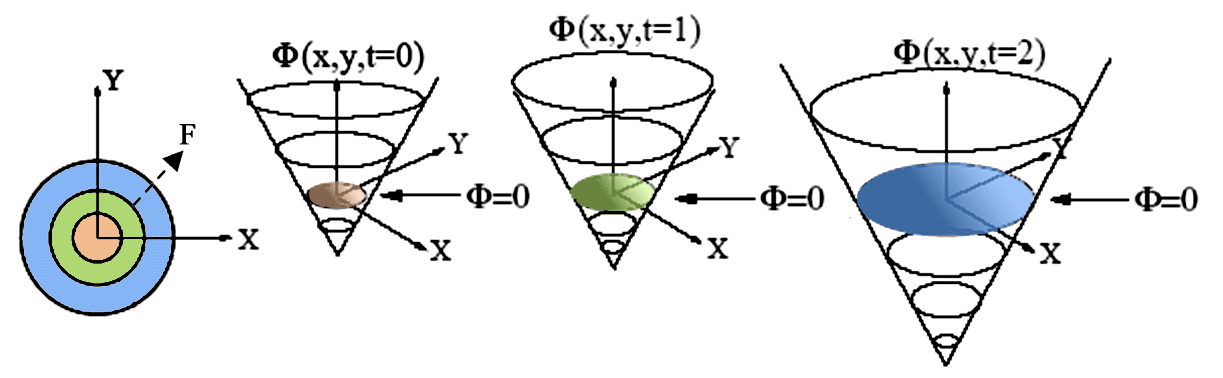

In this method, we have used a new variational level set formulation in which the regularity of the level set function is intrinsically maintained during the level set evolution. The level set evolution is derived as the gradient flow that minimizes an energy functional with a distance regularization term and an external energy that drives the motion of the zero level set toward desired locations. The distance regularization term is defined with a potential function such that the derived level set evolution has a unique forward-and-backward (FAB) diffusion effect, which is able to maintain a desired shape of the level set function, particularly a signed distance profile near the zero level set. This yields a new type of level set evolution called distance regularized level set evolution (DRLSE). The distance regularization effect eliminates the need for reinitialization and thereby avoids its induced numerical errors. In contrast to complicated implementations of conventional level set formulations, a simpler and more efficient finite difference scheme can be used to implement the DRLSE formulation. 

DRLSE also allows the use of more general and efficient initialization of the level set function. In its numerical implementation, relatively large time steps can be used in the finite difference scheme to reduce the number of iterations, while ensuring sufficient.

### Application to Image Segmentation

The general DRLSE formulation in can be used in various applications with different definitions of the external energy Eext. For image segmentation applications, a variety of image information, including region-based or edge-based image formation, can be used to define the external energy.

Let I be an image on a domain $Ω$, we define an edge indicator function $g$ by

$$g \triangleq {1\over 1+\vert \nabla G_\sigma\ast I\vert^2}$$

where $Gσ$ is a Gaussian kernel with a standard deviation $σ$. The convolution in is used to smooth the image to reduce the noise. This function $g$ usually takes smaller values at object boundaries than at other locations.

For an LSF $ϕ:Ω→R$, we define an energy functional $E(ϕ)$ by

$${\cal E}(\phi) = \mu{\cal R}_p(\phi) + \lambda {\cal L}_g(\phi) + \alpha{\cal A}_g(\phi)$$

where $λ>0$ and $α∈R$ are the coefficients of the energy functionals $Lg(ϕ)$ and $Ag(ϕ)$, which are defined by

$$\eqalignno{{\cal L}_g(\phi) &\triangleq \int_{\Omega} g \delta(\phi) \vert \nabla \phi\vert d{\bf x} \cr {\hbox {and}} {\cal A}_g(\phi) &\triangleq \int_\Omega g H(-\phi)d{\bf x} }$$



### Result on applying DRLSE to an Image


In [29]:
import numpy as np
FF = np.zeros((1,1),dtype=np.double)

In [30]:
import os
import cv2
from scipy.misc import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.ndimage.filters as filters
from skimage import measure

from skimage.filters import gabor_kernel
from scipy import ndimage as nd
# prepare filter bank kernels
kernels = []
for theta in range(6):
    theta = theta / 6. * np.pi
    for sigma in range(1, 6):
#     sigma = 2
        for frequency in (0.05, 0.25):
        #         for frequency in (0.05, 0.01, 0.25, 0.1):
        #         frequency = 1.
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)
            print(kernel.shape)
print(len(kernels))

class drlse(object):

    def __init__(self, F, lamda, mu, alpha, epsilon, dt, iterations, potential_function):
        self.F = F
        self.lamda = lamda
        self.alpha = alpha
        self.epsilon = epsilon
        self.dt = dt
        self.mu = mu
        self.iter = iterations
        self.potential_function = potential_function

    def drlse_edge(self,phi):
        [vy, vx] = np.gradient(self.F)
        for k in range(self.iter):
            phi = self.applyNeumann(phi)
            [phi_y, phi_x] = np.gradient(phi)
            s = np.sqrt(np.square(phi_x) + np.square(phi_y))
            smallNumber = 1e-10
            Nx = phi_x / (s + smallNumber)
            Ny = phi_y / (s + smallNumber)
            curvature = self.div(Nx, Ny)
            if self.potential_function == 'single-well':
                distRegTerm = filters.laplace(phi, mode='wrap') - curvature
            elif self.potential_function == 'double-well':
                distRegTerm = self.distReg_p2(phi)
            else:
                print('Error: Wrong choice of potential function. Please input the string "single-well" or "double-well" in the drlse_edge function.')
            diracPhi = self.Dirac(phi)
            areaTerm = diracPhi * self.F
            edgeTerm = diracPhi * (vx * Nx + vy * Ny) + diracPhi * self.F * curvature
            phi = phi + self.dt * (self.mu * distRegTerm + self.lamda * edgeTerm + self.alpha * areaTerm)
        return phi

    def distReg_p2(self,phi):
        [phi_y, phi_x] = np.gradient(phi)
        s = np.sqrt(np.square(phi_x) + np.square(phi_y))
        a = (s >= 0) & (s <= 1)
        b = (s > 1)
        ps = a * np.sin(2 * np.pi * s) / (2 * np.pi) + b * (s - 1)
        dps = ((ps != 0) * ps + (ps == 0)) / ((s != 0) * s + (s == 0))
        return self.div(dps * phi_x - phi_x, dps * phi_y - phi_y) + filters.laplace(phi, mode='wrap')

    def div(self,nx, ny):
        [junk, nxx] = np.gradient(nx)
        [nyy, junk] = np.gradient(ny)
        return nxx + nyy

    def Dirac(self,x):
        f = (1 / 2 / self.epsilon) * (1 + np.cos(np.pi * x / self.epsilon))
        b = (x <= self.epsilon) & (x >= -self.epsilon)
        return f * b

    def applyNeumann(self,f):
        [ny, nx] = f.shape
        g = f.copy()
        g[0, 0] = g[2, 2]
        g[0, nx-1] = g[2, nx-3]
        g[ny-1, 0] = g[ny-3, 2]
        g[ny-1, nx-1] = g[ny-3, nx-3]

        g[0, 1:-1] = g[2, 1:-1]
        g[ny-1, 1:-1] = g[ny-3, 1:-1]

        g[1:-1, 0] = g[1:-1, 2]
        g[1:-1, nx-1] = g[1:-1, nx-3]
        return g



class levelSet(object):

    def __init__(self, drlse_iter, gradient_iter, lamda, alpha, epsilon, sigma, dt=1, potential_function="double-well"):
        self.lamda = lamda
        self.alpha = alpha
        self.epsilon = epsilon
        self.sigma = sigma
        self.dt = dt
        self.mu = 0.2/self.dt
        self.drlse_iter = drlse_iter
        self.gradient_iter = gradient_iter
        self.potential_function = potential_function

    def initializePhiAtScribble(self,image,x,y):
        c0 = 4
        phi = c0 * np.ones(image.shape)
        w = 16
        phi[x-w:x+w, y-w:y+w] = -c0
        return phi

    def visualization(self,image,phi):
        fig2 = plt.figure(2)
        fig2.clf()
        contours = measure.find_contours(phi, 0)
        ax2 = fig2.add_subplot(111)
        ax2.imshow(image, interpolation='nearest', cmap=plt.cm.gray)
        for n, contour in enumerate(contours):
            ax2.plot(contour[:, 1], contour[:, 0], linewidth=2)

    def calculateF_edge(self,image):
        img_smooth = filters.gaussian_filter(image, self.sigma)
        [Iy, Ix] = np.gradient(img_smooth)
        F = np.square(Ix) + np.square(Iy)
        print((1/(1+F)).shape)
        return 1 / (1+F)
    
    def compute_feats(self, image, kernels):
        feats = np.zeros((len(kernels), 2), dtype=np.double)
        for k, kernel in enumerate(kernels):
            #filtered = nd.convolve(image, kernel, mode='wrap')
            filtered = (cv2.filter2D(
                                                        src=image,
                                                        ddepth=-1,
                                                        kernel=kernel,
                                                        dst=0,
                                                        anchor=(-1, -1),
                                                        delta=0,
                                                        borderType=cv2.BORDER_CONSTANT))
    #         cv2.imshow('f',filtered)
            feats[k, 0] = filtered.mean()
            feats[k, 1] = filtered.var()
            #plt.imshow(filtered)
            #plt.pause(0.1)
        return feats

    def calculateF_pattern(self,image,x,y):
        w = 16
        window_scribble = image[x-w:x+w, y-w:y+w]
        scribble_feats = self.compute_feats(window_scribble, kernels)
        
        top, bottom, left, right = w, w-1, w, w-1
        WHITE = [255, 255, 255]
        w = 2
        padded_img = cv2.copyMakeBorder(image, top , bottom, left, right, cv2.BORDER_REPLICATE, value=WHITE)
        
        global FF
        if FF.shape[0] == 1:
            F = np.zeros(image.shape, dtype=np.double)
            step = 8
            for i in range(w, padded_img.shape[0]-w, step):
                print(i)
                for j in range(w, padded_img.shape[1]-w, step):

                    feats = self.compute_feats(padded_img[i-w:i+w, j-w:j+w], kernels)
    #                 print(i,j)
                    F[i-w:i-w+step, j-w:j-w+step] = np.sum((feats - scribble_feats)**2)
                    F[i-w:i-w+step, j-w:j-w+step] = np.sqrt(F[i-w:i-w+step, j-w:j-w+step])
            FF = F
        else:
            F = FF
        
        plt.imshow(F)
        plt.pause(0.3)
        return 1 / (1+F)

    def gradientDescent(self,image,x,y):
        phi = self.initializePhiAtScribble(image,x,y)
#         F = self.calculateF_edge(image)
        F = self.calculateF_pattern(image,x,y)
        print("hi")
        lse = drlse(F, self.lamda, self.mu, self.alpha, self.epsilon, self.dt, self.drlse_iter, self.potential_function)
        for n in range(self.gradient_iter):
            phi = lse.drlse_edge(phi)
#             [phi_y, phi_x] = np.gradient(phi)
#             dphi = np.sqrt(np.square(phi_x) + np.square(phi_y))
#             phi = phi + self.dt * F * dphi
            #print(n)
            if n % 20 == 0:
                #print(n)
                self.visualization(image,phi)
                plt.pause(0.3)
        plt.pause(5)
def func():
    global kernels
    image = cv2.imread('1.png', cv2.IMREAD_GRAYSCALE)
    image = np.array(image,dtype='float32')
    image = (image - image.mean()) / image.std()
    image = cv2.resize(image,(100,100))
    plt.imshow(image)
    plt.pause(0.3)
    ksize = (16,16)
    nscales = 4
    norientations = 6
    min_sigma = 10
    scale_factor = 3

    kernels = get_gabor_filterbank(ksize, nscales, norientations, min_sigma, scale_factor)
    #kernels = build_filters()
    #print(kernels)
    LS = levelSet(4,600,2,-1,1.5,0.2)
    LS.gradientDescent(image,60,50)

(7, 7)
(7, 7)
(13, 13)
(13, 13)
(19, 19)
(19, 19)
(25, 25)
(25, 25)
(31, 31)
(31, 31)
(7, 7)
(7, 7)
(13, 13)
(13, 13)
(17, 17)
(17, 17)
(23, 23)
(23, 23)
(27, 27)
(27, 27)
(7, 7)
(7, 7)
(13, 13)
(13, 13)
(17, 17)
(17, 17)
(23, 23)
(23, 23)
(27, 27)
(27, 27)
(7, 7)
(7, 7)
(13, 13)
(13, 13)
(19, 19)
(19, 19)
(25, 25)
(25, 25)
(31, 31)
(31, 31)
(7, 7)
(7, 7)
(13, 13)
(13, 13)
(17, 17)
(17, 17)
(23, 23)
(23, 23)
(27, 27)
(27, 27)
(7, 7)
(7, 7)
(13, 13)
(13, 13)
(17, 17)
(17, 17)
(23, 23)
(23, 23)
(27, 27)
(27, 27)
60


16
24
32
40
48
56
64
72
80
88
96
104
112


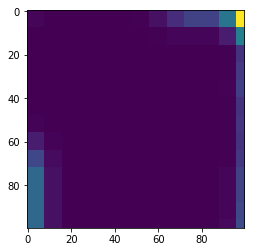

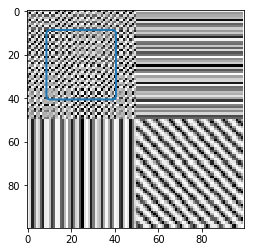

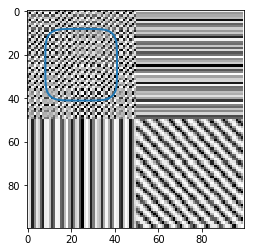

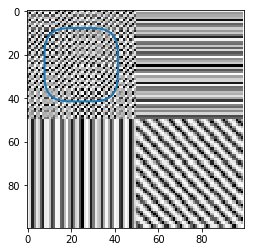

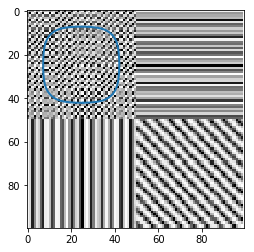

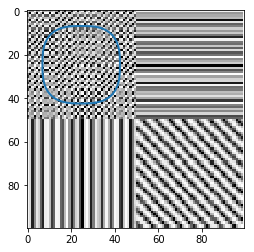

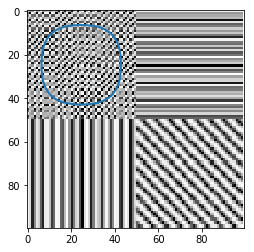

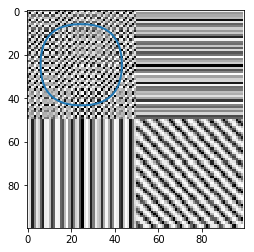

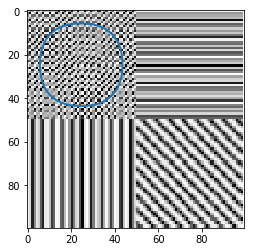

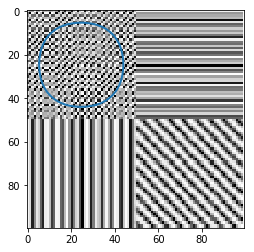

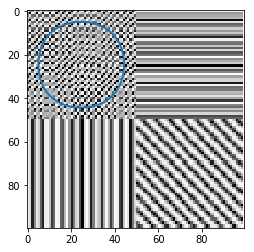

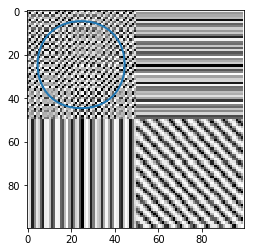

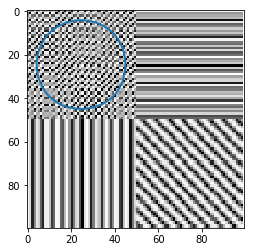

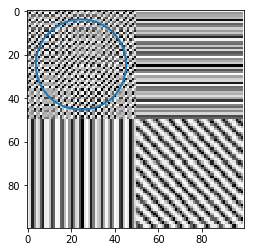

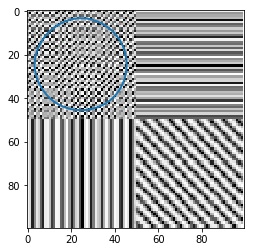

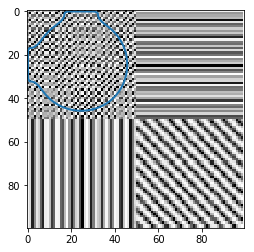

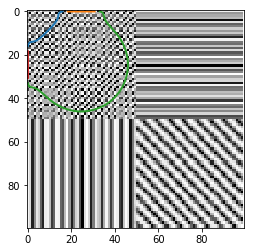

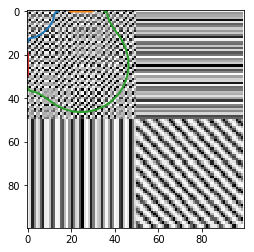

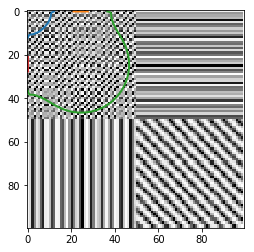

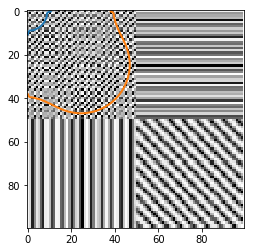

KeyboardInterrupt: 

In [31]:
func()

[[-2.46427655e-02  5.69898903e-01]
 [-7.53342360e-03  1.07658841e-01]
 [-2.12540850e-02  1.84464604e-01]
 [-1.82644580e-04  1.26870768e-02]
 [-1.66232120e-02  5.61416745e-02]
 [-2.47958815e-05  4.01532790e-03]
 [-1.17564322e-02  1.93311311e-02]
 [-9.74017894e-06  1.35204778e-03]
 [-2.46429220e-02  5.75468898e-01]
 [-7.54143670e-03  1.18913069e-01]
 [-2.12587789e-02  2.17529297e-01]
 [-1.92300184e-04  1.00826398e-02]
 [-1.66883469e-02  1.01360902e-01]
 [ 4.37092967e-06  2.67546298e-03]
 [-1.18589029e-02  5.69418930e-02]
 [-2.68308213e-07  1.02591491e-03]
 [-2.46429294e-02  5.75379729e-01]
 [-7.54143856e-03  1.16318934e-01]
 [-2.12587807e-02  2.17953712e-01]
 [-1.92299020e-04  9.24161356e-03]
 [-1.66883469e-02  1.00619309e-01]
 [ 4.37092967e-06  2.45293742e-03]
 [-1.18589019e-02  5.57189733e-02]
 [-2.68453732e-07  1.31411804e-03]
 [-2.46427543e-02  5.69713116e-01]
 [-7.53342453e-03  1.01082593e-01]
 [-2.12540794e-02  1.85167402e-01]
 [-1.82644930e-04  8.61095171e-03]
 [-1.66232139e-02  5

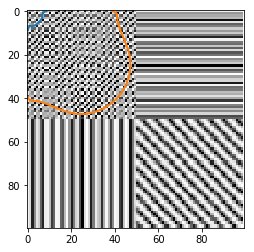

hi


ValueError: operands could not be broadcast together with shapes (534,575) (100,100) 

In [15]:
image = cv2.imread('pattern.PNG', cv2.IMREAD_GRAYSCALE)
image = np.array(image,dtype='float32')
image = (image - image.mean()) / image.std()
image = cv2.resize(image,(100,100))

LS = levelSet(2,400,1,-0.1,1,0.8)
LS.gradientDescent(image,25,25)

### Conclusion

- We've finished coding the DRLSE variant of level set method that can detect region
- We're working on implementing Gabor wavelet method for finding feature set in pattern continuous region
- We're working on how to apply colors to these regions

In [ ]:
"""
=============================================
Gabor filter banks for texture classification
=============================================

In this example, we will see how to classify textures based on Gabor filter
banks. Frequency and orientation representations of the Gabor filter are similar
to those of the human visual system.

The images are filtered using the real parts of various different Gabor filter
kernels. The mean and variance of the filtered images are then used as features
for classification, which is based on the least squared error for simplicity.

"""
from __future__ import print_function

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as nd

from skimage import data
from skimage.util import img_as_float
from skimage.filters import gabor_kernel


def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = nd.convolve(image, kernel, mode='wrap')
#         cv2.imshow('f',filtered)
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats


def match(feats, ref_feats):
    min_error = np.inf
    min_i = None
    for i in range(ref_feats.shape[0]):
        error = np.sum((feats - ref_feats[i, :])**2)
        if error < min_error:
            min_error = error
            min_i = i
    return min_i


# prepare filter bank kernels
kernels = []
for theta in range(6):
    theta = theta / 6. * np.pi
#     for sigma in (1, 3):
    sigma = 1
    for frequency in (0.05, 0.015, 0.25, 0.035):
        kernel = np.real(gabor_kernel(frequency, theta=theta,
                                      sigma_x=sigma, sigma_y=sigma))
        kernels.append(kernel)
print(len(kernels))

shrink = (slice(0, None, 3), slice(0, None, 3))
print(shrink[0])
brick = img_as_float(data.load('brick.png'))[shrink]
grass = img_as_float(data.load('grass.png'))[shrink]
wall = img_as_float(data.load('rough-wall.png'))[shrink]
image_names = ('brick', 'grass', 'wall')
images = (brick, grass, wall)

# prepare reference features
ref_feats = np.zeros((3, len(kernels), 2), dtype=np.double)
ref_feats[0, :, :] = compute_feats(brick, kernels)
ref_feats[1, :, :] = compute_feats(grass, kernels)
ref_feats[2, :, :] = compute_feats(wall, kernels)

print('Rotated images matched against references using Gabor filter banks:')

print('original: brick, rotated: 30deg, match result: ', end='')
feats = compute_feats(nd.rotate(brick, angle=30, reshape=False), kernels)
print(image_names[match(feats, ref_feats)])
print(feats.shape)

print('original: brick, rotated: 70deg, match result: ', end='')
feats = compute_feats(nd.rotate(brick, angle=70, reshape=False), kernels)
print(image_names[match(feats, ref_feats)])

print('original: grass, rotated: 145deg, match result: ', end='')
feats = compute_feats(nd.rotate(grass, angle=145, reshape=False), kernels)
print(image_names[match(feats, ref_feats)])


def power(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(nd.convolve(image, np.real(kernel), mode='wrap')**2 +
                   nd.convolve(image, np.imag(kernel), mode='wrap')**2)

# Plot a selection of the filter bank kernels and their responses.
results = []
kernel_params = []
for theta in (0, 1):
    theta = theta / 4. * np.pi
    for frequency in (0.1, 0.4):
        kernel = gabor_kernel(frequency, theta=theta)
        params = 'theta=%d,\nfrequency=%.2f' % (theta * 180 / np.pi, frequency)
        kernel_params.append(params)
        # Save kernel and the power image for each image
        results.append((kernel, [power(img, kernel) for img in images]))

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(5, 6))
plt.gray()

fig.suptitle('Image responses for Gabor filter kernels', fontsize=12)

axes[0][0].axis('off')

# Plot original images
for label, img, ax in zip(image_names, images, axes[0][1:]):
    ax.imshow(img)
    ax.set_title(label, fontsize=9)
    ax.axis('off')

for label, (kernel, powers), ax_row in zip(kernel_params, results, axes[1:]):
    # Plot Gabor kernel
    ax = ax_row[0]
    ax.imshow(np.real(kernel), interpolation='nearest')
    ax.set_ylabel(label, fontsize=7)
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot Gabor responses with the contrast normalized for each filter
    vmin = np.min(powers)
    vmax = np.max(powers)
    for patch, ax in zip(powers, ax_row[1:]):
        ax.imshow(patch, vmin=vmin, vmax=vmax)
        ax.axis('off')

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x,y = 70,150
c0 = 4
phi = c0 * np.ones(image.shape)
phi[x-5:x+5, y-3:y+3] = -c0

def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = nd.convolve(image, kernel, mode='wrap')
#         cv2.imshow('f',filtered)
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats
    
window_scribble = image[x-8:x+8, y-8:y+8]
scribble_feats = compute_feats(window_scribble, kernels)

top, bottom, left, right = 8, 7, 8, 7
WHITE = [255, 255, 255]
padded_img = cv2.copyMakeBorder(image, top , bottom, left, right, cv2.BORDER_REPLICATE, value=WHITE)

F = np.zeros(image.shape, dtype=np.double)
step = 4
for i in range(8, padded_img.shape[0]-8, step):
    for j in range(8, padded_img.shape[0]-8, step):

        feats = compute_feats(padded_img[i-8:i+8, j-8:j+8], kernels)
#                 print(i,j)
        F[i-8:i-8+step, j-8:j-8+step] = np.sum((feats - scribble_feats)**2)
        F[i-8:i-8+step, j-8:j-8+step] = np.sqrt(F[i-8:i-8+step, j-8:j-8+step])

F = 1 / (1+F)
dt = 1
it = 100

for i in range(it):
    dphi = np.array( np.gradient(phi) )
    [phi_y, phi_x] = np.gradient(phi)
    dphi = np.sqrt(np.square(phi_x) + np.square(phi_y))
    print(dphi.shape)
    phi = phi + dt * F * dphi#_norm
    print(phi.shape)
    # plot the zero level curve of phi
    plt.contour(phi, 0)
    plt.show()

In [28]:
image = cv2.imread('1.png', cv2.IMREAD_GRAYSCALE)
image_result_gabor = np.abs(cv2.filter2D(
    src=image,
    ddepth=-1,
    kernel=gabor_kernel,
    dst=0,
    anchor=(-1, -1),
    delta=0,
    borderType=cv2.BORDER_CONSTANT))

In [25]:
def get_gabor_kernel(ksize, sigma, theta, lambd, gamma, psi, ktype=np.float):
    '''
    Returns Gabor filter coefficients.
    Implementation by: Cristiano Fraga G. Nunes <cfgnunes@gmail.com>.
    ksize: Size of the filter returned.
    sigma: Standard deviation of the gaussian envelope.
    theta: Orientation of the normal to the
           parallel stripes of a Gabor function.
    lambd: Wavelength of the sinusoidal factor.
    gamma: Spatial aspect ratio.
    psi: Phase offset.
    ktype: Type of filter coefficients (e.g. np.float).
    '''

    costheta = np.cos(theta)
    sintheta = np.sin(theta)

    width, height = ksize
    half_width = int(width / 2)
    half_height = int(height / 2)

    # Kernel matrix
    kernel = np.zeros((height, width), ktype)

    const_x = -0.5 / (sigma ** 2)
    const_y = -0.5 / ((float(sigma) / gamma) ** 2)
    const_scale = np.pi * 2.0 / lambd

    for i in range(height):
        for j in range(width):
            # Use symmetric references
            y, x = i - half_height, j - half_width

            # Rotate the filter
            xr = x * costheta + y * sintheta
            yr = -x * sintheta + y * costheta

            # Gabor equation
            value = np.exp(const_x * xr * xr + const_y * yr * yr) * \
                np.cos(const_scale * xr + psi)

            kernel.itemset(i, j, value)

    return kernel


In [27]:
ksize = (11, 11)
sigma = 1.6
theta = np.pi
lambd = 10
gamma = 1.0
psi = np.pi * 0.5

gabor_kernel = get_gabor_kernel(ksize, sigma, theta, lambd, gamma, psi)

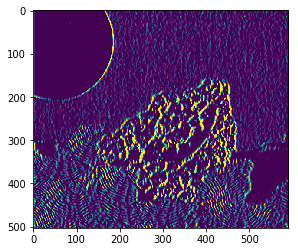

In [29]:
plt.imshow(image_result_gabor)

In [30]:
def get_gabor_filterbank(ksize, n_scales, n_orientations, min_sigma=1.0,
                         scale_factor=3, gamma=1.0, psi=np.pi * 0.5,
                         ktype=np.float):
    '''
    Returns a Gabor filter bank.
    Implementation by: Cristiano Fraga G. Nunes <cfgnunes@gmail.com>.
    ksize: Size of the filters.
    n_scales: Number of scales.
    n_orientations: Number of orientations.
    min_sigma: Sigma of smallest scale filter
    scale_factor: Scaling factor between successive filters
    gamma: Spatial aspect ratio of filters.
    psi: Phase offset of filters.
    ktype: Type of filter coefficients (e.g. np.float).
    '''

    filters = []

    for scale in range(n_scales):
        for orientation in range(n_orientations):
            sigma = min_sigma + scale
            lambd = sigma * scale_factor
            theta = 2 * np.pi * (orientation / float(n_orientations))

            f = get_gabor_kernel(
                ksize, sigma, theta, lambd, gamma, psi, ktype)
            filters.append(f)

    return filters


In [33]:
ksize = (50, 50)
nscales = 4
norientations = 6
min_sigma = 1.0
scale_factor = 3

gabor_filterbank = get_gabor_filterbank(ksize, nscales, norientations, min_sigma, scale_factor)